# Notebook aim:
   * Load datafrom 82146 dataset
   * Write a dataloader with image standardization
   * train an instance segmentation algo:
       * jan 2024: try a segformer based on pytorch lightning with the help of bard/chatgpt 3.5

In [ ]:
!conda install -c huggingface transformers

# Import the modules

In [1]:
#from fastai.vision import *
import os, sys
#import multiprocessing as mp

In [2]:
#import h5py
import numpy as np
from matplotlib import pyplot as plt

In [3]:
import torch
#import pytorch_lightning as pl
#import torch.optim as optim
#from pytorch_lightning import LightningModule

In [4]:
#import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#import torch.nn.functional as F
#import pytorch_lightning as pl

In [5]:
import torch.optim as optim
from torchvision import transforms

In [6]:
from transformers import SegformerForSemanticSegmentation
#from datasets import load_dataset, load_metric

In [6]:
print(torch.cuda.get_device_properties(0))

_CudaDeviceProperties(name='NVIDIA GeForce GTX 960', major=5, minor=2, total_memory=4030MB, multi_processor_count=8)


In [7]:
print(torch.__version__)
print(torch.cuda.get_device_properties(0))
#print(pl.__version__)

2.1.2
_CudaDeviceProperties(name='NVIDIA GeForce GTX 960', major=5, minor=2, total_memory=4030MB, multi_processor_count=8)


In [8]:
#info regarding cpu cores (only flags)
!awk '{if ($0=="") exit; print $0}' /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 26
model name	: Intel(R) Xeon(R) CPU           X5570  @ 2.93GHz
stepping	: 5
microcode	: 0x1d
cpu MHz		: 1596.000
cache size	: 8192 KB
physical id	: 0
siblings	: 8
core id		: 0
cpu cores	: 4
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 11
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ht tm pbe syscall nx rdtscp lm constant_tsc arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf pni dtes64 monitor ds_cpl vmx est tm2 ssse3 cx16 xtpr pdcm dca sse4_1 sse4_2 popcnt lahf_lm pti ssbd ibrs ibpb stibp tpr_shadow vnmi flexpriority ept vpid dtherm ida flush_l1d
vmx flags	: vnmi preemption_timer invvpid ept_x_only flexpriority tsc_offset vtpr mtf vapic ept vpid
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs itlb_multihit mmio_unknown
bogomips	: 5852.43
clflush size	: 64
cach

In [9]:
!ls -l ./|grep npz

-rw-rw-r--  1 jeanpat jeanpat 352413073 juil. 27 11:33 82146_chromosomes_compressed.npz
-rw-rw-r--  1 jeanpat jeanpat  10626293 juil. 22  2023 82146_masks_compressed.npz


## Display some a pair of image groundtruth

### Load cleaned masks and chromosomes as two separated arrays

In [10]:
c_data = np.load('./82146_masks_compressed.npz')
masks = c_data['x']
chroms = np.load('./82146_chromosomes_compressed.npz')
images = chroms['x']

In [11]:
plt.rcParams['figure.figsize'] = [10, 5]

(82146, 52, 52) (82146, 52, 52, 2)


(-0.5, 51.5, 51.5, -0.5)

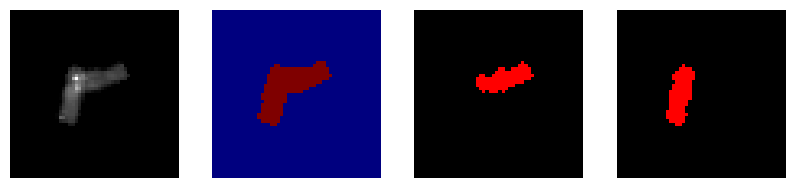

In [25]:
N = 13841
im = images[N,:,:]
#gt = dataset[N,:,:,1]
mask1, mask2 = masks[N,:,:,0], masks[N,:,:,1]
mask = im > 0
print(images.shape, masks.shape)

#plt.Figure(figsize=(15,15))

plt.subplot(141)
plt.imshow(im, cmap=plt.cm.gray); plt.axis('off')
#plt.imshow(images[50,:,:], cmap=plt.cm.gray); plt.axis('off')

plt.subplot(142)
plt.imshow(im > 1, interpolation= "nearest", cmap=plt.cm.jet); plt.axis('off')

plt.subplot(143)
plt.imshow(mask1, interpolation= "nearest", cmap=plt.cm.flag_r); plt.axis('off')

plt.subplot(144)
plt.imshow(mask2, interpolation= "nearest", cmap=plt.cm.flag_r); plt.axis('off')

# Dataloader

In [26]:
# Dataset class
class ChromDataset(Dataset):

    def __init__(self, data_images, data_masks_1, data_masks_2):
        """get three numpys arrays:images, masks1,masks2
         assume the three have the same shape.
         for this implementaion (82146,52,52)
        """
        self.im_data = data_images
        self.masks_1 = data_masks_1
        self.masks_2 = data_masks_2
        print(self.im_data.shape)
        print(self.masks_1.shape)
        print(self.masks_2.shape)
        
        
    def __len__(self):
        return self.im_data.shape[0]
    
    def __getitem__(self, idx):
        """return a standardized image and its two associated masks
        """
        image = self.im_data[idx,:,:] 
        
        cmask = np.logical_or(self.masks_1[idx,:,:],self.masks_2[idx,:,:])
        
        # Calculate mean and std only from masked regions
        mean = image[cmask].mean() 
        std = image[cmask].std()
        #normalization
        image = (image-mean)/std
        
        # Convert image and masks to PyTorch tensors
        image = torch.from_numpy(image).float()
        cmask1 = torch.from_numpy(self.masks_1[idx,:,:]).float()#why float? is there some int or binary?
        cmask2 = torch.from_numpy(self.masks_2[idx,:,:]).float() 
        
        
        return image, cmask1, cmask2

### Check the dataloader

In [27]:
datachrom = ChromDataset(images, masks[:,:,:,0],masks[:,:,:,1])
print(datachrom.__len__())
I,M1,M2 = datachrom.__getitem__(41093)
print(I.shape)

(82146, 52, 52)
(82146, 52, 52)
(82146, 52, 52)
82146
torch.Size([52, 52])


In [28]:
# Create the dataloader
dataloader = DataLoader(datachrom, batch_size=16, shuffle=True)

# Iterate over the dataloader
for images, masks_1, masks_2 in dataloader:
    # Do something with the images and masks the images and masks
    print(type(images), images.shape)
    break

<class 'torch.Tensor'> torch.Size([16, 52, 52])


## send to a segformer Bar Gemini version

In [29]:
#import torch
#from torch.utils.data import DataLoader
#from transformers import SegformerForSemanticSegmentation

# Dataset setup
#dataset = YourDataset(images_path, masks1_path, masks2_path)  # Replace with your dataset class

train_set, val_set, test_set = torch.utils.data.random_split(datachrom, [65717, 8214, 8215])  # Split dataset

In [36]:
sample0 = train_set[1]

(-0.5, 51.5, 51.5, -0.5)

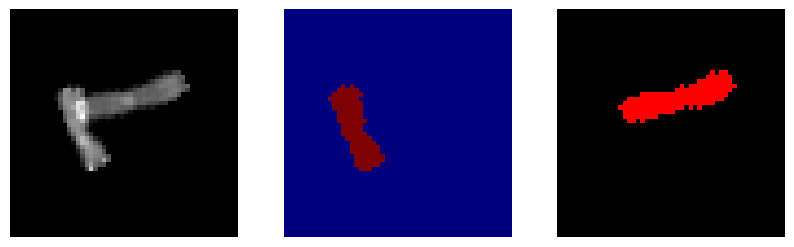

In [37]:
plt.subplot(131)
plt.imshow(sample0[0], cmap=plt.cm.gray); plt.axis('off')
#plt.imshow(images[50,:,:], cmap=plt.cm.gray); plt.axis('off')

plt.subplot(132)
plt.imshow(sample0[1], interpolation= "nearest", cmap=plt.cm.jet); plt.axis('off')

plt.subplot(133)
plt.imshow(sample0[2], interpolation= "nearest", cmap=plt.cm.flag_r); plt.axis('off')


In [17]:
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16)
test_loader = DataLoader(test_set, batch_size=16)

In [24]:
from transformers import SegformerConfig

In [20]:
# Optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

In [21]:
# Training loop
for epoch in range(2):
    for images, masks1, masks2 in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks1) + criterion(outputs, masks2)  # Combine losses for both masks
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for images, masks1, masks2 in val_loader:
            outputs = model(images)
            val_loss += criterion(outputs, masks1) + criterion(outputs, masks2)
    print(f"Epoch {epoch}, Validation Loss: {val_loss.item() / len(val_loader)}")

# Testing loop (similar to validation)

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[1, 16, 52, 52] to have 3 channels, but got 16 channels instead

## Prepare the dataset
split into train, validate and test
### Code from Bard +Gemini

In [ ]:
from transformers import SegformerForSemanticSegmentation

# Dataset setup
##dataset = YourDataset(images_path, masks1_path, masks2_path)  # Replace with your dataset class

train_set, val_set, test_set = torch.utils.data.random_split(datachrom, [65717, 8214, 8215])  # Split dataset
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16)
test_loader = DataLoader(test_set, batch_size=16)

In [ ]:
# Load the SegFormer model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b5")  # Load a pre-trained model

# Optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
for epoch in range(10):
    for images, masks1, masks2 in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks1) + criterion(outputs, masks2)  # Combine losses for both masks
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for images, masks1, masks2 in val_loader:
            outputs = model(images)
            val_loss += criterion(outputs, masks1) + criterion(outputs, masks2)
    print(f"Epoch {epoch}, Validation Loss: {val_loss.item() / len(val_loader)}")

# Testing loop (similar to validation)

## Training code by chatgpt

Préparation des données :
Assure-toi que tes données d'entraînement sont organisées correctement. Tu devras probablement utiliser un DataLoader pour charger tes lots de données.

Création du modèle SegFormer :
Utilise la classe ViTFeatureExtractor de la bibliothèque Transformers pour extraire les caractéristiques des images, puis utilise ces caractéristiques pour construire ton modèle SegFormer.

In [ ]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
import torch

# Charger le feature extractor
feature_extractor = ViTFeatureExtractor(model_name="your_pretrained_model_name")

# Créer le modèle SegFormer
model = ViTForImageClassification.from_pretrained("your_pretrained_model_name")

# Modifier la tête de classification pour l'adaptation à la segmentation
model.classifier = torch.nn.Conv2d(in_channels=model.config.hidden_size, out_channels=num_classes, kernel_size=1)



Entraînement du modèle :
Entraîne ton modèle avec tes données d'entraînement. Utilise une fonction de perte adaptée à la segmentation, comme la perte de segmentation croisée (torch.nn.CrossEntropyLoss).

In [ ]:
import torch.optim as optim
from torch.nn import CrossEntropyLoss

# Définir l'optimiseur
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Définir la fonction de perte
criterion = CrossEntropyLoss()

# Boucle d'entraînement
for epoch in range(num_epochs):
    for images, masks in dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()


## Segformer by claude

In [ ]:
# Load dataset 
dataset = load_dataset('my_dataset') 

# Split into train, val, test
train_dataset = dataset['train']
val_dataset = dataset['validation'] 
test_dataset = dataset['test']

# Define model
model = SegformerForSemanticSegmentation.from_pretrained('nvidia/segformer-b0-finetuned-ade-512-512')

# Send model to GPU
model.to('cuda') 

# Define optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

# Define loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train loop
for epoch in range(10):
  
  for batch in train_dataset:
    
    # Get input images and target masks
    images = batch['images'].to('cuda')  
    mask1 = batch['mask1'].to('cuda')
    mask2 = batch['mask2'].to('cuda')
    
    # Forward pass   
    outputs = model(images)  
    
    # Compute loss 
    loss1 = loss_fn(outputs[0], mask1) 
    loss2 = loss_fn(outputs[1], mask2)
    loss = loss1 + loss2
    
    # Backward pass
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
  # Validation loop
  # Calculate metrics
  # Print results

# Test loop 
# Make predictions
# Calculate metrics

## Definissons un algo ViT

In [ ]:
class ViTSegmentation(pl.LightningModule):

    def __init__(self, image_size=(52, 52), num_classes=10, vit_model="vit_b16"):
        super().__init__()
        self.image_size = image_size
        self.num_classes = num_classes
        self.vit = vit_model.from_pretrained(vit_model)
        self.linear = nn.Linear(self.vit.embed_dim, self.num_classes)

    def forward(self, x):
        x = self.vit(x)
        x = self.linear(x)
        return x

    def training_step(self, batch, batch_idx):
        images, masks_1, masks_2 = batch
        output = self(images)
        loss = F.cross_entropy(output, masks_1)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, masks_1, masks_2 = batch
        output = self(images)
        loss = F.cross_entropy(output, masks_1)
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=0.001)

## modèle et fitting

In [ ]:
# Train the model
trainer.fit(model, dataloaders)

In [ ]:
# Assuming you have loaded your data into these variables

train_images = images[:60000,:,:]
train_masks = masks[:60000,:,:,:]
val_images = images[60000:75000,:,:]
val_masks = masks[60000:75000,:,:,:]
test_images = images[75000:,:,:]
test_masks = masks[75000:,:,:,:]

In [ ]:
data_module = DataModule(train_images, train_masks, val_images, val_masks, test_images, test_masks)
model = InstanceSegmentationModel()

In [ ]:
# Initialize a Trainer and train your model
trainer = pl.Trainer(max_epochs=3)

In [ ]:
trainer.fit(model, data_module)

In [ ]:
class SegmentationModel(pl.LightningModule):

    def __init__(self):
        super().__init__()
       # PyTorch Transformer 
        d_model = 52 #512
        nhead = 4
        dim_feedforward = 2048 
        dropout = 0.1

        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)  

        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)
        
        # Segmentation head
        self.segmentation_head = nn.Sequential(
           nn.Conv2d(16, 1, kernel_size=1),
           nn.Conv2d(1, 64, kernel_size=3, padding=1),
           nn.ReLU(),
           nn.Conv2d(64, 2, kernel_size=1)
        )

        # Other init steps
        self.loss_fn = nn.BCELoss()
    
   
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer
    
    def forward(self, x):
        # Forward pass
        feats = self.encoder(x) 
        
        preds = self.decoder(feats, memory=feats)
        preds = self.segmentation_head(preds)
        return preds
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        self.log('train_loss', loss)
        return loss
    
    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        print(f"Epoch {self.current_epoch} done. Average Train Loss: {avg_loss.item()}")
    
    def validation_step(self, batch, batch_idx):
        # Validation step
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        self.log('val_loss', loss)
        
    def test_step(self, batch, batch_idx):
        # Test step
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        self.log('test_loss', loss)
        
    

In [ ]:
# Create dataset and dataloader
train_dataset = SegmentationDataset(images[:50000], masks[:50000]) 
val_dataset = SegmentationDataset(images[50000:70000], masks[50000:70000])
test_dataset = SegmentationDataset(images[70000:], masks[70000:])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16) 
test_loader = DataLoader(test_dataset, batch_size=16)

In [ ]:
model = SegmentationModel()

In [ ]:
trainer = pl.Trainer()

In [ ]:
trainer.fit(model, train_loader, val_loader)